In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.ensemble import GradientBoostingRegressor

In [23]:
csv_path = Path("Housing.csv")
df = pd.read_csv(csv_path)
target_col = "price"
y = df[target_col].values
X = df.drop(columns=[target_col, "rownames"])
X.head()

,lotsize,bedrooms,bathrms,stories,driveway,recroom,fullbase,gashw,airco,garagepl,prefarea
0,5850,3,1,2,yes,no,yes,no,no,1,no
1,4000,2,1,1,yes,no,no,no,no,0,no
2,3060,3,1,1,yes,no,no,no,no,0,no
3,6650,3,1,2,yes,yes,no,no,no,0,no
4,6360,2,1,1,yes,no,no,no,no,0,no


In [24]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    # ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
from sklearn.model_selection import KFold, GridSearchCV

gbr = GradientBoostingRegressor(random_state=42)


pipeline = Pipeline([
    ("preprocess", preprocess),
    ("gbr", gbr)
])

param_grid = {
    "gbr__max_depth": [2, 3, 4],
    "gbr__learning_rate": [0.05, 0.1],
    "gbr__min_samples_split": [2,5,10],
    "gbr__subsample": [1.0,0.8],
    "gbr__n_estimators": [300, 500],
    "gbr__min_samples_leaf": [1, 3, 5]

}

cv = KFold(n_splits=5, shuffle=True, random_state=42)
gs = GridSearchCV(estimator=pipeline,
                  param_grid=param_grid,
                  cv=cv,
                  scoring="neg_mean_squared_error",
                  n_jobs=-1,
                  verbose=0
                  )

gs.fit(X_train, y_train)
best_model = gs.best_estimator_
gs.best_params_

{'gbr__learning_rate': 0.05,
 'gbr__max_depth': 2,
 'gbr__min_samples_leaf': 1,
 'gbr__min_samples_split': 10,
 'gbr__n_estimators': 300,
 'gbr__subsample': 0.8}

In [26]:
from sklearn.metrics import root_mean_squared_error, r2_score


def rmse(y_true, y_pred):
    return root_mean_squared_error(y_true, y_pred)

y_pred = best_model.predict(X_test)
print(f"Target: {target_col}")
print(f"Best params: {gs.best_params_}")
print(f"R^2 (test): {r2_score(y_test, y_pred):.4f}")
print(f"RMSE (test): {rmse(y_test, y_pred):.2f}")

Target: price
Best params: {'gbr__learning_rate': 0.05, 'gbr__max_depth': 2, 'gbr__min_samples_leaf': 1, 'gbr__min_samples_split': 10, 'gbr__n_estimators': 300, 'gbr__subsample': 0.8}
R^2 (test): 0.6605
RMSE (test): 15059.50


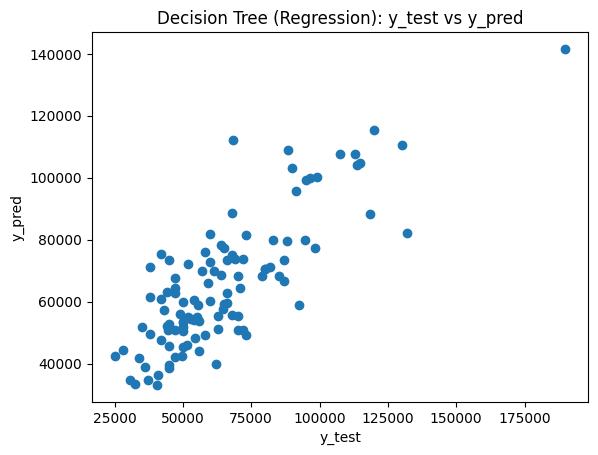

,feature,importance
0,lotsize,0.466164
2,bathrms,0.149983
4,garagepl,0.092362
13,airco_no,0.067680
3,stories,0.063476
14,airco_yes,0.032015
1,bedrooms,0.023322
9,fullbase_no,0.020267
15,prefarea_no,0.014835
6,driveway_yes,0.011584


In [27]:
# y_test vs y_pred
plt.figure()
plt.scatter(y_test, y_pred)
plt.title("Decision Tree (Regression): y_test vs y_pred")
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

# Имена признаков после one-hot
oh = None
if categorical_features:
    oh = best_model.named_steps["preprocess"].transformers_[1][1].named_steps["onehot"]
num_names = numeric_features
cat_names = oh.get_feature_names_out(categorical_features).tolist() if oh is not None else []
feature_names = num_names + cat_names

# Важности
importances = best_model.named_steps["gbr"].feature_importances_
imp_df = (pd.DataFrame({
    "feature": feature_names if len(feature_names)==len(importances) else [f"f{i}" for i in range(len(importances))],
    "importance": importances
})
.sort_values("importance", ascending=False)
.head(10))

imp_df

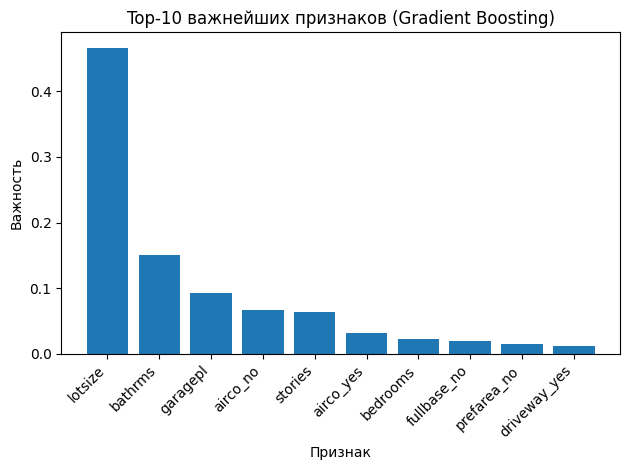

In [29]:
plt.figure()
plt.bar(imp_df["feature"], imp_df["importance"])
plt.title("Top-10 важнейших признаков (Gradient Boosting)")
plt.xlabel("Признак")
plt.ylabel("Важность")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()